In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting
import stats
#import pystan

reload(misc)
reload(plotting)

first_year = 1992

data_dir = '.'
data_file = os.path.join(data_dir, 'immigration_with_metadata_2017_03_13.csv')
data = misc.read_article_data(data_file, first_year, rename_frames=True)
print "Loaded data for %d articles" % len(data.index)

data['tone'] = data['Pro'] - data['Anti']

tone_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_tone_annotations.csv'), first_year)
print "Loaded tone annotations for %d articles" % len(tone_annotations.index)

tone_annotations['tone'] = tone_annotations['Pro'] - tone_annotations['Anti']

#framing_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_framing_annotations.csv'), first_year)
#framing_annotations = misc.compute_entropy(framing_annotations)
#print "Loaded framing annotations for %d articles" % len(framing_annotations.index)

last_date = data['date'].max()
print "Last date = ", last_date
last_year = last_date.year + 1


Loaded data for 33868 articles
Loaded tone annotations for 3857 articles
Last date =  2012-12-31 00:00:00


In [54]:
# extract periods from dates
reload(misc)
data = misc.convert_dates(data, first_year)
tone_annotations = misc.convert_dates(tone_annotations, first_year)
#framing_annotations = misc.convert_dates(framing_annotations, first_year)
print "Done"

Done


Grouped data into 84 periods


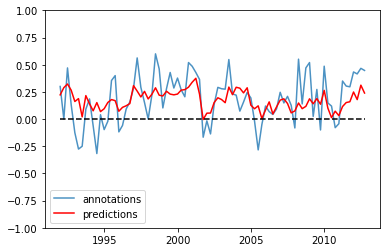

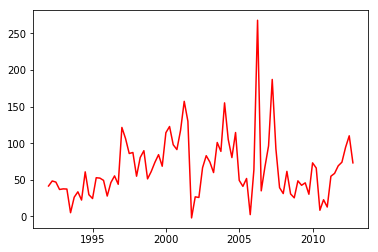

In [55]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'
#group_by = 'year'

reload(misc)
reload(plotting)

grouped = misc.group_article_data(data, group_by, first_year, group_tone=True, group_frames=True, group_directness=True)
grouped_tone_annotations = misc.group_article_data(tone_annotations, group_by, first_year, group_tone=True)
#grouped_framing_annotations = misc.group_article_data(framing_annotations, group_by, first_year, group_frames=True)

print "Grouped data into %d periods" % len(grouped.index)

fig, ax = plt.subplots()
#ax.fill_between(grouped_tone_annotations.f_date,  tone+tone_sd*2, tone-tone_sd*2, facecolor='grey', edgecolor='white', alpha=0.6)
ax.plot(grouped_tone_annotations.f_date, grouped_tone_annotations.tone / grouped_tone_annotations.stories, label='annotations', alpha=0.8)
ax.plot(grouped.f_date, grouped.tone / grouped.stories , 'r', label='predictions')
ax.plot([grouped.f_date.min(), grouped.f_date.max()], [0, 0], 'k--')
#ax.plot(grouped.f_date, grouped.Pro, c='purple', label='Pro')
#ax.plot(grouped.f_date, grouped.Anti, c='orange', label='Anti')
#ax.plot(grouped.f_date, grouped.Neutral, c='green', label='Neutral')
ax.legend(loc='lower left')
ax.set_ylim(-1, 1)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.tone , 'r', label='(Net) tone')


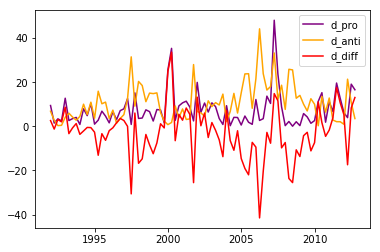

In [56]:
grouped = misc.compute_entropy(grouped)
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']
    
grouped = misc.compute_dominance(grouped)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.d_pro, c='purple', label='d_pro')
ax.plot(grouped.f_date, grouped.d_anti, c='orange', label='d_anti')
grouped['d_diff'] = grouped['d_pro'] - grouped['d_anti']
ax.plot(grouped.f_date, grouped.d_pro - grouped.d_anti, c='red', label='d_diff')
ax.legend()

#fig, ax = plt.subplots()
#ax.plot(grouped.f_date, grouped.tone * grouped.stories, c='green', label='toneXstories')
#ax.legend()

set(['#1b9e77', '#d95f02', '#e7298a', '#e6ab02', '#66a61e', '#7570b3'])


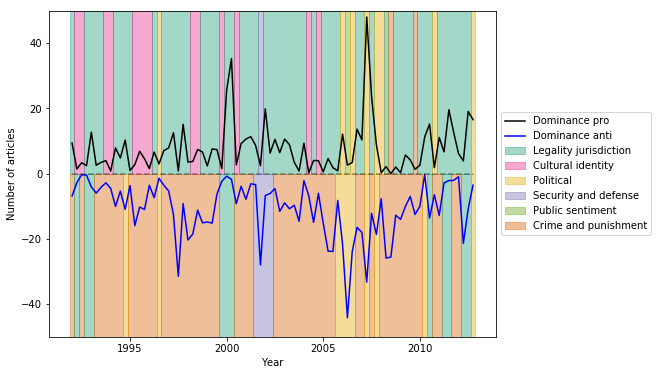

In [113]:
import re
reload(misc)
grouped = misc.compute_entropy(grouped)
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']

CB6 = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02']


threshold = 0
grouped = misc.compute_dominance(grouped, threshold=threshold)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(grouped.f_date, grouped.d_pro, c='black', label='Dominance pro')
ax.plot(grouped.f_date, -grouped.d_anti, c='blue', label='Dominance anti')
grouped['d_diff'] = grouped['d_pro'] - grouped['d_anti']
#grouped['d_diff2'] = grouped['d_pro2'] - grouped['d_anti2']
#ax.plot(grouped.f_date, grouped.d_pro - grouped.d_anti, c='red', label='d_diff')

pos_spans = []
anti_spans = []
pos_cur = -1
anti_cur = -1
top_set = set()
delta = grouped.iloc[1].f_date - grouped.iloc[0].f_date

for i, index in enumerate(grouped.index):
    row = grouped.loc[index]
    if row.top_pro != pos_cur:
        if i > 0 and pos_cur >= 0:
            pos_spans[-1] += [row.f_date - delta/2.0, pos_cur]
        if i < len(grouped.index) and row.top_pro >= 0:
            pos_spans.append([row.f_date - delta/2.0])
        pos_cur = row.top_pro
    if i == len(grouped.index) - 1 and pos_cur >= 0:
        pos_spans[-1] += [row.f_date + delta/2.0, pos_cur]
    top_set.add(int(row.top_pro))

    if row.top_anti != anti_cur:
        if i > 0 and anti_cur >= 0:
            anti_spans[-1] += [row.f_date - delta/2.0, anti_cur]
        if i < len(grouped.index) and row.top_anti >= 0:
            anti_spans.append([row.f_date - delta/2.0])
        anti_cur = row.top_anti
    if i == len(grouped.index) - 1 and anti_cur >= 0: 
        anti_spans[-1] += [row.f_date + delta/2.0, anti_cur]
    top_set.add(int(row.top_anti))


# UNCOMMENT THIS LINE TO REFRESH COLOURS
#colors = dict(zip(list(top_set), CB6))

ylim = 50

colors_used = set()
for span in pos_spans:
    start, end, frame = span
    color = colors[frame]
    if color in colors_used:
        ax.axvspan(start, end, ymin=0.5, ymax=1, alpha=0.4, facecolor=color, edgecolor=color, label=None)
    else:
        ax.axvspan(start, end, ymin=0.5, ymax=1, alpha=0.4, facecolor=color, edgecolor=color, label=re.sub('_', ' ', misc.FRAMES[int(frame)]))
        colors_used.add(color)

for span in anti_spans:
    start, end, frame = span
    color = colors[frame]
    if color in colors_used:
        ax.axvspan(start, end, ymin=0, ymax=0.5, alpha=0.4, facecolor=color, edgecolor=color, label=None)
    else:
        ax.axvspan(start, end, ymin=0, ymax=0.5, alpha=0.4, facecolor=color, edgecolor=color, label=re.sub('_', ' ', misc.FRAMES[int(frame)]))
        colors_used.add(color)

print colors_used

ax.plot(grouped.f_date, np.ones_like(grouped.f_date)*threshold, 'k--', alpha=0.2)
ax.plot(grouped.f_date, -np.ones_like(grouped.f_date)*threshold, 'k--', alpha=0.2)
ax.set_ylim(-50, 50)
ax.set_ylabel('Number of articles')
ax.set_xlabel('Year')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('/Users/dcard/Desktop/immigration_dominance_' + str(threshold) + '.pdf', bbox_inches='tight')

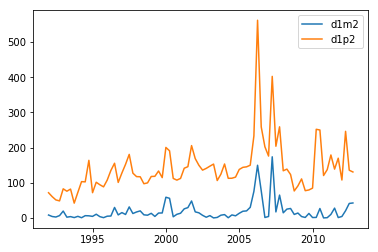

In [7]:
fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.d1m2, label='d1m2')
ax.plot(grouped.f_date, grouped.d1p2, label='d1p2')
ax.legend()
grouped['toneXd1m2'] = grouped['tone'] * grouped['d1m2']
grouped['toneXd1p2'] = grouped['tone'] * grouped['d1p2']



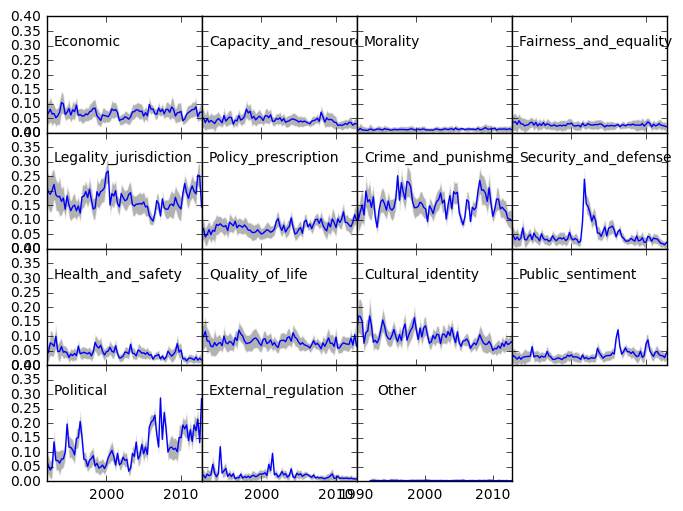

In [219]:
reload(plotting)
plotting.plot_frames(grouped, ymax=0.4)

### Load polls

1990
Loaded 76 polls
     Varname   House     Date  Topic  Subcode   L1    L2   L3   L4   C2  \
68   PSRAIMM    PSRA  5/28/92    120      124  6.0  15.0  0.0  0.0  0.0   
44  IMMLEGAL  CBSNYT  6/21/93    120      124  6.0  27.0  0.0  0.0  0.0   
16   IMMKEPT  GALLUP   7/9/93    120      124  6.0  27.0  0.0  0.0  0.0   
69   PSRAIMM    PSRA  7/13/94    120      124  5.0  12.0  0.0  0.0  0.0   
45  IMMLEGAL  CBSNYT   9/8/94    120      124  6.0  27.0  0.0  0.0  0.0   

      ...      f_date  period  f_date_0  IMMKEPT  IMMLEGAL CNNIMM  PSRAIMM  \
68    ...     1992.25       9      2.25        0         0      0        1   
44    ...     1993.25      13      3.25        0         1      0        0   
16    ...     1993.50      14      3.50        1         0      0        0   
69    ...     1994.50      18      4.50        0         0      0        1   
45    ...     1994.50      18      4.50        0         1      0        0   

    SPIMMIG  IMMRATE  question  
68        0        0      

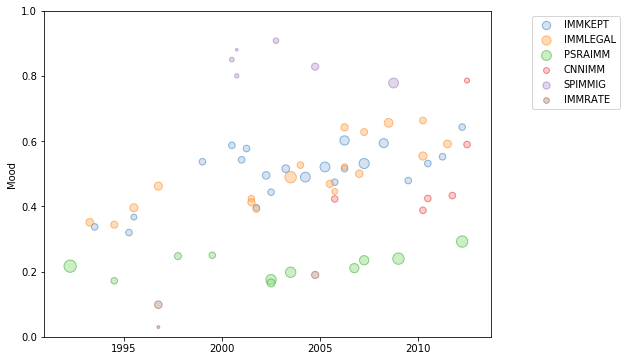

In [48]:
reload(misc)

#filename = 'immigration_polls.csv'
filename = 'immigration_polls_dedup_merge.csv'
print first_year
polls = misc.load_polls(filename, first_year, last_date + pd.DateOffset(years=4))
# drop one poll that seems redundant (with a seeming mistake)
#polls = polls[polls['Varname'] != 'IMMLEGAL']
polls = misc.get_f_dates(polls, first_year, group_by)
print "Loaded %d polls" % len(polls.index)

# add in indicator variables for each question
varnames = polls['Varname'].values
#questions = list(set(varnames))
#questions.sort()
questions = misc.get_top_poll_questions(polls, n=len(varnames)+1)
question_index = dict(zip(questions, range(len(questions))))    
for q_i, q in enumerate(questions):
    polls.ix[:, q] = 0
for q_i, q in enumerate(questions):
    polls.ix[polls['Varname']==q, 'question'] = q_i
    polls.ix[polls['Varname']==q, q] = 1
print polls.head() 

reload(plotting)
#plotting.plot_polling_data(polls)

polls = polls[polls['date'] <= last_date]

fig, ax = plotting.plot_polling_data(polls, transform=False)
ax.set_ylabel('Mood')
#plt.savefig('/Users/dcard/Desktop/imm_polls.pdf', bbox_inches='tight')
#ax.plot(grouped.f_date, grouped.mood, label='Estimated mood')
plt.savefig('/Users/dcard/Desktop/imm_polls_with_mood.pdf', bbox_inches='tight')

### Load data from wcalc

/Users/dcard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in log


(0, 1)

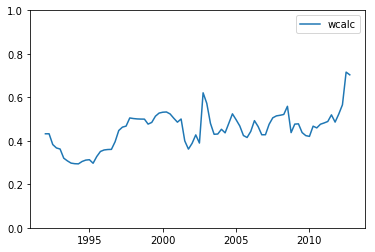

In [57]:
# Load data from wcalc
# specify the location of the mood data file
reload(misc)

group_by = 'quarter'
# read the mood data into a dataframe
if group_by == 'quarter':
    #mood = pd.read_csv('wcalc_immigration_quarter.csv', header=0)
    #mood = pd.read_csv('wcalc_immigration_quarter_unsmoothed.csv', header=0)
    mood = pd.read_csv('wcalc_immigration_dedup_merge_quarter_smoothed.csv', header=0)
    mood['date'] = [pd.Timestamp(pd.datetime(int(mood.loc[i].year), (int(mood.loc[i].quarter))*3, 1)) for i in mood.index]
#elif group_by == 'month':
#    mood = pd.read_csv('wcalc_immigration_month.csv', header=0)
#    mood['date'] = [pd.Timestamp(pd.datetime(int(mood.loc[i].year), int(mood.loc[i].month), 1)) for i in mood.index]
else:
    sys.exit()

mood = mood[mood['date'] >= pd.datetime(first_year, 1, 1)]
mood = mood[mood['date'] <= last_date]  

mood = misc.convert_dates(mood, first_year)
mood = misc.get_f_dates(mood, first_year, group_by)
mood.index = mood.p_quarter

# normalize and transform mood
mood['mood'] = mood['mood'] / 100.0
mood['transformed'] = np.log(mood.mood / (1 - mood.mood))

# store the vector of mood values from the previous quarter as a separate vector
mood['prev_mood'] = mood['mood'].shift().as_matrix()
mood['prev_transformed'] = mood['transformed'].shift().as_matrix()


# copy the mood data into the grouped dataframe (with the framing data)
grouped['mood'] = mood.mood
grouped['transformed'] = mood.transformed
grouped['prev_mood'] = mood.prev_mood
grouped['prev_transformed'] = mood.prev_transformed
grouped['mood_diff'] = grouped['mood'] - grouped['prev_mood']
grouped['transformed_diff'] = grouped['transformed'] - grouped['prev_transformed']

grouped['logTone'] = np.log(grouped['tone'] / np.mean(grouped['tone']))

#temp = pd.read_csv('immigration_grouped.csv')
#grouped['p_t'] = temp['p_t_means']
#grouped['prev_p_t'] = grouped['p_t'].shift().values

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.mood, label='wcalc')
#ax.plot(grouped.f_date, grouped.p_t, label='p_t')
ax.legend()
plt.ylim(0, 1)

## Approach 1: predict wcalc values from wcalc + other

### Compare some models through standard OLS

In [61]:
reload(stats)
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['f_date'])
print np.mean(grouped.mood - fitted)
print np.std(grouped.mood - fitted)

Rmse: 0.0673001047882
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     48.01
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           8.82e-10
Time:                        15:18:43   Log-Likelihood:                 108.50
No. Observations:                  84   AIC:                            -213.0
Df Residuals:                      82   BIC:                            -208.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -16.3544      2.4

In [69]:
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood'])


Rmse: 0.044183675558
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     220.4
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           7.92e-25
Time:                        15:31:33   Log-Likelihood:                 142.15
No. Observations:                  83   AIC:                            -280.3
Df Residuals:                      81   BIC:                            -275.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0456      0.02

In [70]:
grouped['normalized_tone'] = grouped['tone'] / np.max(grouped['tone'].values)
fitted, rmse, model = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_tone'])


Rmse: 0.0424052042266
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     123.6
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           3.38e-25
Time:                        15:32:12   Log-Likelihood:                 146.08
No. Observations:                  83   AIC:                            -286.2
Df Residuals:                      80   BIC:                            -278.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           

In [27]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'logTone'])


Rmse: 0.0429022869185
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     118.1
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           1.82e-24
Time:                        12:27:06   Log-Likelihood:                 143.38
No. Observations:                  82   AIC:                            -280.8
Df Residuals:                      79   BIC:                            -273.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0729      0.0

In [59]:
divisor = np.max([np.max(grouped['Pro'].values), np.max(grouped['Anti'].values)])
grouped['normalized_pro'] = grouped['Pro'] / divisor
grouped['normalized_anti'] = grouped['Anti'] / divisor
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_pro', 'normalized_anti'])


Rmse: 0.042651401033
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     81.49
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           4.10e-24
Time:                        14:54:12   Log-Likelihood:                 146.12
No. Observations:                  83   AIC:                            -284.2
Df Residuals:                      79   BIC:                            -274.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0

In [68]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.0433014953467
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     78.28
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           1.35e-23
Time:                        15:24:44   Log-Likelihood:                 144.86
No. Observations:                  83   AIC:                            -281.7
Df Residuals:                      79   BIC:                            -272.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept       

ValueError: too many values to unpack

In [42]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_tone', 'normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.0405382437778
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     68.45
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           6.32e-26
Time:                        13:56:17   Log-Likelihood:                 165.15
No. Observations:                  91   AIC:                            -320.3
Df Residuals:                      86   BIC:                            -307.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept       

In [41]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor

fitted, rmse = stats.ols(df=grouped, target='transformed', columns=['prev_transformed', 'normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.170461701387
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     89.54
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           1.65e-26
Time:                        13:49:25   Log-Likelihood:                 33.923
No. Observations:                  91   AIC:                            -59.85
Df Residuals:                      87   BIC:                            -49.80
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept        

In [18]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor

fitted, rmse = stats.ols(df=grouped, target='mood_diff', columns=['normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.0441594665017
                            OLS Regression Results                            
Dep. Variable:              mood_diff   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.744
Date:                Sat, 08 Apr 2017   Prob (F-statistic):              0.181
Time:                        11:25:13   Log-Likelihood:                 142.71
No. Observations:                  83   AIC:                            -279.4
Df Residuals:                      80   BIC:                            -272.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept       

In [19]:
divisor = np.max([np.max(grouped['d_pro'].values), np.max(grouped['d_anti'].values)])
grouped['normalized_d_pro'] = grouped['d_pro'] / divisor
grouped['normalized_d_anti'] = grouped['d_anti'] / divisor

fitted, rmse = stats.ols(df=grouped, target='transformed_diff', columns=['normalized_d_pro', 'normalized_d_anti'])


Rmse: 0.181916880147
                            OLS Regression Results                            
Dep. Variable:       transformed_diff   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.780
Date:                Sat, 08 Apr 2017   Prob (F-statistic):              0.175
Time:                        11:25:28   Log-Likelihood:                 25.205
No. Observations:                  83   AIC:                            -44.41
Df Residuals:                      80   BIC:                            -37.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept        

In [25]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'd_diff'])


Rmse: 0.0442950657394
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     110.0
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           1.11e-23
Time:                        12:01:02   Log-Likelihood:                 142.46
No. Observations:                  83   AIC:                            -278.9
Df Residuals:                      80   BIC:                            -271.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0473      0.0

In [201]:
grouped['normalized_d_diff'] = grouped['d_diff'] / np.max(grouped['d_diff'].values)
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'normalized_d_diff'])


Rmse: 0.0442950657394
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     110.0
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           1.11e-23
Time:                        12:42:50   Log-Likelihood:                 142.46
No. Observations:                  83   AIC:                            -278.9
Df Residuals:                      80   BIC:                            -271.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept       

In [173]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy'])


Rmse: 0.0403585062767
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     94.09
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           5.30e-26
Time:                        10:10:34   Log-Likelihood:                 150.70
No. Observations:                  83   AIC:                            -293.4
Df Residuals:                      79   BIC:                            -283.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.7266      0.2

In [174]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy', 'toneXentropy'])


Rmse: 0.0402264921651
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     71.41
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           2.66e-25
Time:                        10:10:36   Log-Likelihood:                 151.50
No. Observations:                  83   AIC:                            -293.0
Df Residuals:                      78   BIC:                            -280.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.2989   

In [175]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'toneXentropy'])


Rmse: 0.0400501763047
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     95.95
Date:                Thu, 06 Apr 2017   Prob (F-statistic):           2.90e-26
Time:                        10:10:36   Log-Likelihood:                 151.34
No. Observations:                  83   AIC:                            -294.7
Df Residuals:                      79   BIC:                            -285.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.0698   

In [71]:
columns = ['prev_mood']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'Pro', 'Anti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'd_pro', 'd_anti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

Held-out RMSE: 0.0447501857734 ['prev_mood']
Held-out RMSE: 0.0430749609506 ['prev_mood', 'tone']
Held-out RMSE: 0.0435175527874 ['prev_mood', 'Pro', 'Anti']
Held-out RMSE: 0.0440719836965 ['prev_mood', 'd_pro', 'd_anti']


### Compare some models using leave-one-out CV

In [176]:
columns = ['prev_mood']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'Pro', 'Anti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'd_diff']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'd_pro', 'd_anti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone', 'd_pro', 'd_anti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone', 'd_diff']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'toneXentropy']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone', 'entropy']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone', 'entropy', 'toneXentropy']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone', 'toneXentropy']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns

columns = ['prev_mood', 'tone', 'entropy_pro', 'entropy_anti', 'toneXentropyPro', 'toneXentropyAnti']
predictions, rmse = stats.eval_loocv(grouped, 'mood', columns)
print "Held-out RMSE:", rmse, columns


Held-out RMSE: 0.0447501857734 ['prev_mood']
Held-out RMSE: 0.0430749609506 ['prev_mood', 'tone']
Held-out RMSE: 0.0435175527874 ['prev_mood', 'Pro', 'Anti']
Held-out RMSE: 0.0450115083423 ['prev_mood', 'd_diff']
Held-out RMSE: 0.0440719836965 ['prev_mood', 'd_pro', 'd_anti']
Held-out RMSE: 0.0433862076805 ['prev_mood', 'tone', 'd_pro', 'd_anti']
Held-out RMSE: 0.0432307359385 ['prev_mood', 'tone', 'd_diff']
Held-out RMSE: 0.0432972241014 ['prev_mood', 'toneXentropy']
Held-out RMSE: 0.0413755866625 ['prev_mood', 'tone', 'entropy']
Held-out RMSE: 0.0420432330458 ['prev_mood', 'tone', 'entropy', 'toneXentropy']
Held-out RMSE: 0.0417864112525 ['prev_mood', 'tone', 'toneXentropy']
Held-out RMSE: nan ['prev_mood', 'tone', 'entropy_pro', 'entropy_anti', 'toneXentropyPro', 'toneXentropyAnti']


stats.py:53: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nanmean((np.array(true_values) - np.array(predictions))**2))


### Try running a Bayesian linear regression model

In [200]:
model = """
/*
*Simple normal regression example
*/

data {
  int N; //the number of observations
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
  
  y ~ normal(linpred,sigma);
}
"""


In [201]:
import statsmodels.api as sm

columns = ['prev_transformed', 'tone', 'entropy', 'toneXentropy']

X = grouped[columns].copy()
X = sm.add_constant(X).values[1:, :]
N, K = X.shape
y = grouped['transformed'].values[1:]

data = {'N': N, 'K': K, 'y': y, 'X': X}

# fit the model
fit = pystan.stan(model_code=model, data=data, iter=1000, chains=4)

betas = fit.extract('beta')['beta']
betas_means = np.mean(betas, axis=0)
betas_stds2 = np.std(betas, axis=0) * 2
for c_i, c in enumerate(['Intercept'] + columns):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, betas_means[c_i] - betas_stds2[c_i], betas_means[c_i], betas_means[c_i] + betas_stds2[c_i])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67a5fef2fa8062f0d36b04444770661b NOW.


           Intercept 	  -3.7018  -0.1125  3.4768
    prev_transformed 	  0.6739  0.8164  0.9590
                tone 	  -0.0030  0.0374  0.0778
             entropy 	  -1.5053  0.0013  1.5078
        toneXentropy 	  -0.0318  -0.0150  0.0019


In [202]:
import statsmodels.api as sm

columns = ['prev_transformed', 'd_pro', 'd_anti']

X = grouped[columns].copy()
X = sm.add_constant(X).values[1:, :]
N, K = X.shape
y = grouped['transformed'].values[1:]

data = {'N': N, 'K': K, 'y': y, 'X': X}

# fit the model
fit = pystan.stan(model_code=model, data=data, iter=1000, chains=4)

betas = fit.extract('beta')['beta']
betas_means = np.mean(betas, axis=0)
betas_stds2 = np.std(betas, axis=0) * 2
for c_i, c in enumerate(['Intercept'] + columns):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, betas_means[c_i] - betas_stds2[c_i], betas_means[c_i], betas_means[c_i] + betas_stds2[c_i])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67a5fef2fa8062f0d36b04444770661b NOW.


           Intercept 	  -0.1595  -0.0666  0.0263
    prev_transformed 	  0.7549  0.8877  1.0206
               d_pro 	  0.0006  0.0066  0.0126
              d_anti 	  -0.0037  0.0019  0.0075


## Approach 2: predicting poll results from wcalc

In [7]:
reload(misc)

# grab tone and prev_mood data for each poll
tones = []
a_tones = []
prev_moods = []
stories = []
entropies = []
for i in polls.index:
    if group_by == 'month':
        period = polls.loc[i]['p_month']
    elif group_by == 'quarter':
        period = polls.loc[i]['p_quarter']
    tones.append(grouped.loc[period]['tone'])
    a_tones.append(grouped.loc[period]['tone_a'])
    prev_moods.append(mood.loc[period-1]['prev_mood'])
    stories.append(grouped.loc[period]['stories'])
    entropies.append(grouped.loc[period]['entropy'])
polls['tone'] = tones
polls['aTone'] = a_tones
polls['prev_mood'] = prev_moods
polls['prev_transformed'] = np.log(polls.prev_mood / (1 - polls.prev_mood))
polls['stories'] = stories
polls['logStories'] = np.log(stories) - np.mean(np.log(stories))
polls['entropy'] = entropies
polls['toneXstories'] = polls['tone'] * polls['stories']
polls['toneXlogStories'] = polls['tone'] * polls['logStories']
polls['toneXentropy'] = polls['tone'] * polls['entropy']
polls['aToneXlogStories'] = polls['aTone'] * polls['logStories']
polls = misc.combine_polls_with_preceeding_articles(polls, data, n_days=30, include_tone=True, include_frames=True)



In [11]:
reload(stats)
poll_names = misc.get_top_poll_questions(polls)[1:]
columns = ['prev_mood', 'pTone', 'pLogStories', 'pEntropy', 'pToneXpLogStories', 'pToneXpEntropy'] + poll_names
target = 'value'
fitted, rmse = stats.ols(df=polls, target=target, columns=columns, weight_column='N')
predictions, rmse_cv = stats.eval_loocv(polls, target, columns, weight_column='N')
print rmse_cv

Rmse: 0.0651904746696
                            WLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.884
Model:                            WLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     38.70
Date:                Sun, 02 Apr 2017   Prob (F-statistic):           3.75e-22
Time:                        14:48:00   Log-Likelihood:                 91.048
No. Observations:                  68   AIC:                            -158.1
Df Residuals:                      56   BIC:                            -131.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept       

In [857]:
reload(stats)
poll_names = misc.get_top_poll_questions(polls)[1:]
columns = ['prev_transformed', 'tone', 'logStories', 'entropy'] + poll_names
target = 'transformed'
fitted, rmse = stats.ols(df=polls, target=target, columns=columns, weight_column='N')
predictions, rmse_cv = stats.eval_loocv(polls, target, columns, weight_column='N')
print rmse_cv

Rmse: 0.291878602894
                            WLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.891
Model:                            WLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     52.81
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           1.14e-24
Time:                        17:58:56   Log-Likelihood:                -12.079
No. Observations:                  68   AIC:                             44.16
Df Residuals:                      58   BIC:                             66.35
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3


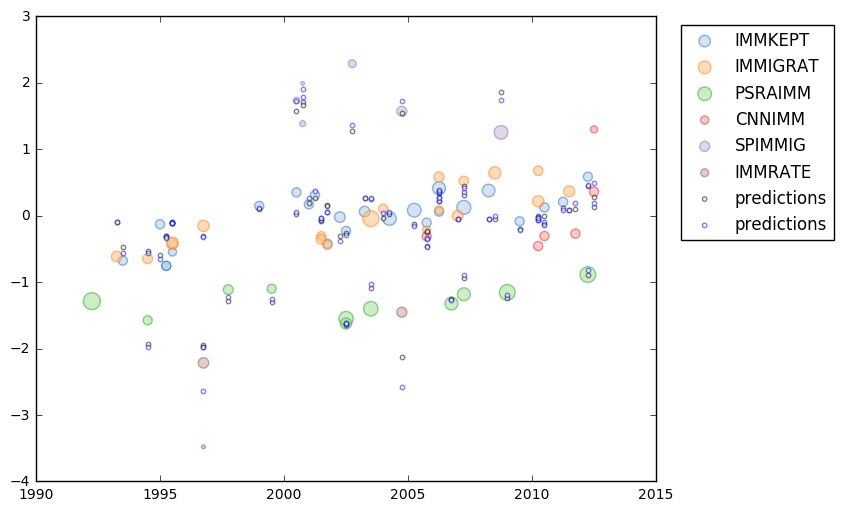

In [825]:
fig, ax = plotting.plot_polling_data(polls, transform=True)
ax.scatter(polls.f_date, predictions, s=10, facecolor='white', edgecolor='black', label='predictions', alpha=0.5)
ax.scatter(polls.f_date, predictions2, s=10, facecolor='white', edgecolor='blue', label='predictions', alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

### Try a hierarchical Bayesian model

In [8]:
model = """
/*
*Hierarchical model for polls
*/

data {
  int N; // the number of observations
  int K; // the number of columns in the model matrix
  int P; // number of poll indicators
  real y[N]; // the response
  matrix[N,K] X; // the model matrix
  matrix[N,P] polls_matrix;
}
parameters {
  vector[K] beta; // the regression parameters
  vector[P] poll_offsets; 
  real offset_mean;
  real<lower=0> offset_std;
  real<lower=0> sigma; // the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred = X * beta + polls_matrix * poll_offsets;
}
model {  
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5); //prior for the slopes following Gelman 2008

  for(j in 1:P)
    poll_offsets[j] ~ normal(offset_mean, offset_std);

  offset_mean ~ normal(0, 1);
  offset_std ~ cauchy(0, 2.5);

  y ~ normal(linpred,sigma);
}
"""



In [866]:
target = 'transformed'
columns = ['prev_transformed', 'tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone']
poll_names = misc.get_top_poll_questions(polls)

X = polls[columns].copy()
polls_indicators = polls[poll_names].values[1:, :]
X = sm.add_constant(X).values[1:, :]
N, K = X.shape
P = len(poll_names)
y = polls[target].values[1:]

stan_data = {'N': N, 'K': K, 'P': P, 'y': y, 'X': X, 'polls_matrix': polls_indicators}

# fit the model
fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

betas = fit.extract('beta')['beta']
betas_means = np.mean(betas, axis=0)
betas_stds2 = np.std(betas, axis=0) * 2
for c_i, c in enumerate(['Intercept'] + columns):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, betas_means[c_i] - betas_stds2[c_i], betas_means[c_i], betas_means[c_i] + betas_stds2[c_i])
    
offsets = fit.extract('poll_offsets')['poll_offsets']
offset_means = np.mean(offsets, axis=0)
offset_stds2 = np.std(offsets, axis=0) * 2
for c_i, c in enumerate(poll_names):
    print "%20s \t  %0.4f  %0.4f  %0.4f" % (c, offset_means[c_i] - offset_stds2[c_i], offset_means[c_i], offset_means[c_i] + offset_stds2[c_i])    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e510440cbefb6c7a37977e69248e032e NOW.


           Intercept 	  -1.1780  3.2411  7.6603
    prev_transformed 	  0.0740  0.3930  0.7120
                tone 	  -7.3217  2.3655  12.0526
             stories 	  -0.0013  0.0004  0.0020
        toneXstories 	  -0.0103  -0.0001  0.0101
             entropy 	  -3.2673  -1.7349  -0.2026
        entropyXtone 	  -4.2246  -0.3461  3.5324
             IMMKEPT 	  -1.9412  0.5158  2.9729
            IMMIGRAT 	  -1.9493  0.5046  2.9586
             PSRAIMM 	  -3.2527  -0.7925  1.6678
              CNNIMM 	  -2.0282  0.4214  2.8710
             SPIMMIG 	  -0.3162  2.1428  4.6018
             IMMRATE 	  -4.1237  -1.6329  0.8579


0.0708061612021


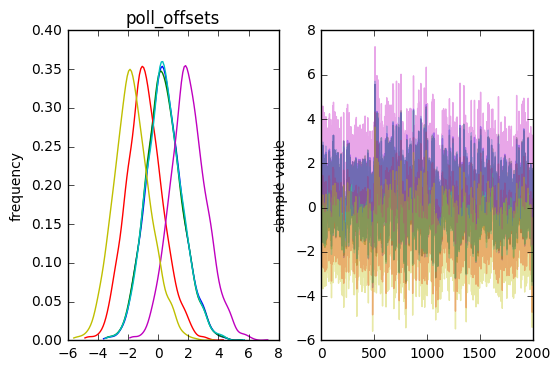

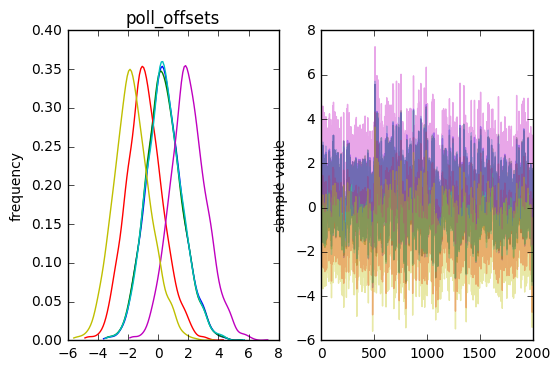

In [863]:
print np.mean(fit.extract('offset_mean')['offset_mean'])
fit.plot('poll_offsets')

In [860]:
reload(stats)
poll_names = misc.get_top_poll_questions(polls)[1:]
columns = ['prev_transformed', 'tone', 'logStories', 'toneXlogStories'] + poll_names
target = 'transformed'
fitted, rmse = stats.ols(df=polls, target=target, columns=columns)
print rmse_cv

Rmse: 0.372592881738
                            OLS Regression Results                            
Dep. Variable:            transformed   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     42.86
Date:                Wed, 29 Mar 2017   Prob (F-statistic):           2.15e-22
Time:                        18:00:45   Log-Likelihood:                -23.945
No. Observations:                  68   AIC:                             67.89
Df Residuals:                      58   BIC:                             90.09
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          

## Approach 3: Try estimating my own latent state of mood

### Try estimating a latent mood using only the polls

In [181]:
# MODEL with no temporal covariates (just polls)

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);

p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1], sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



In [183]:
tones = grouped.tone.values
n_periods = len(tones)
n_polls, _ = polls.shape
periods = np.array(polls.p_quarter.values, dtype=int) + 1
n_questions = int(polls.question.max() + 1) 
question_indices = np.array(polls.question.values, dtype=int) + 1
question_indicators = np.zeros([n_polls, n_questions])
for i in range(n_polls):
    question_indicators[i, int(polls.question.values[i])] = 1
    
y = np.array((polls.value * polls.N).values, dtype=int)
t = np.array(polls.p_quarter.values, dtype=int) + 1
stan_data = {'N': n_polls, 'T': n_periods, 'Q': n_questions,
             'y': y, 't': periods, 'n': polls.N.values, 'q': question_indicators,
             'N_new': n_polls,
             'y_new': y, 't_new': periods, 'n_new': polls.N.values, 'q_new': question_indicators}
n_chains = 4
n_iter = 2000
fit = pystan.stan(model_code=model, data=stan_data, iter=n_iter, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses
 IMMKEPT	22
IMMLEGAL	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3


''

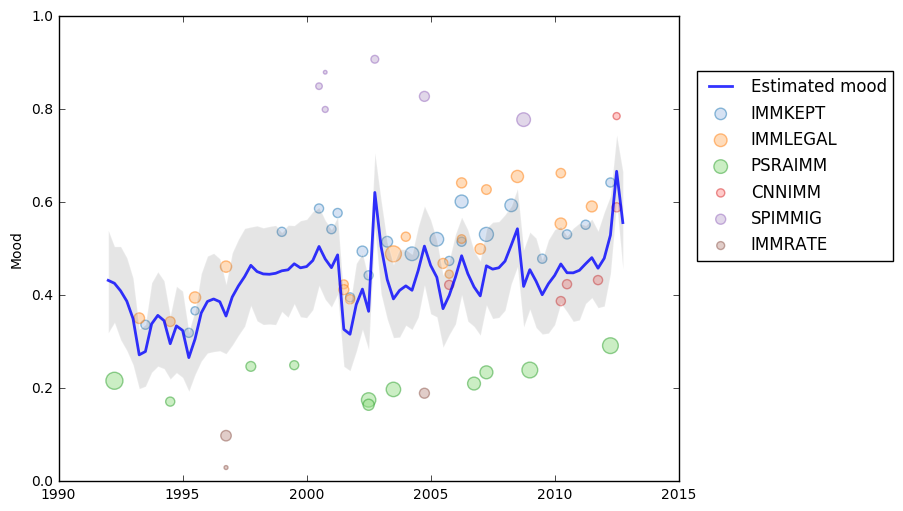

In [195]:
reload(plotting)

p_t = fit.extract('p_t')['p_t']
p_i = fit.extract('p_i')['p_i']
p_t_means = np.mean(p_t, axis=0)
p_t_25 = np.percentile(p_t, 25, axis=0)
p_t_75 = np.percentile(p_t, 75, axis=0)
p_i_means = np.mean(p_i, axis=0)
p_i_25 = np.percentile(p_i, 25, axis=0)
p_i_75 = np.percentile(p_i, 75, axis=0)
fig, ax = plotting.plot_polling_data(polls)
x = [first_year + (q) * 0.25 for q in range(n_periods)]
ax.fill_between(x,  p_t_25, p_t_75, facecolor='grey', edgecolor='white', alpha=0.2, label=None)
#for i in range(n_chains):
#    ax.plot(x, np.mean(p_t[i*n_iter/2:(i+1)*n_iter/2, :], axis=0), 'b', linewidth=0.5, alpha=0.8, label=None)    
ax.plot(x, p_t_means, 'b', linewidth=2, alpha=0.8, label='Estimated mood')
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
#ax.scatter(polls.f_date, p_i_means, s=5, facecolor='black', edgecolor='black', label='Fit', alpha=0.5)
#for i in range(n_polls):
#    f_date = polls.f_date.iloc[i]
#    ax.plot([f_date, f_date], [p_i_25[i], p_i_75[i]], 'k', label=None, alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.36,0.9))

#fit.plot('alpha')
#fit.plot('beta')
#fit.plot('gamma')
#fit.plot('offsets')

ax.set_ylabel('Mood')
plt.savefig('/Users/dcard/Desktop/imm_polls_with_bayesian_estimate.pdf', bbox_inches='tight')
""

In [13]:
grouped['p_t_means'] = p_t_means
print grouped['p_t_means']
grouped.to_csv('immigration_grouped.csv')

p_quarter
0     0.434633
1     0.418096
2     0.408634
3     0.390369
4     0.353133
5     0.264871
6     0.271983
7     0.346875
8     0.365731
9     0.351599
10    0.288208
11    0.362518
12    0.380901
13    0.257835
14    0.299972
15    0.367008
16    0.391593
17    0.396621
18    0.388017
19    0.347507
20    0.395078
21    0.415457
22    0.432117
23    0.457117
24    0.441353
25    0.434780
26    0.435907
27    0.437578
28    0.445590
29    0.444972
        ...   
54    0.417245
55    0.392092
56    0.431209
57    0.477320
58    0.438573
59    0.409776
60    0.390518
61    0.455994
62    0.444441
63    0.444458
64    0.457012
65    0.500218
66    0.536586
67    0.411349
68    0.447505
69    0.422423
70    0.393811
71    0.418311
72    0.435195
73    0.459742
74    0.440769
75    0.437064
76    0.442256
77    0.460206
78    0.473153
79    0.450563
80    0.467191
81    0.521526
82    0.661007
83    0.528929
Name: p_t_means, dtype: float64


/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0bbbb53ef295d2fc6e96eb7a1ddc43dd NOW.


fold 4


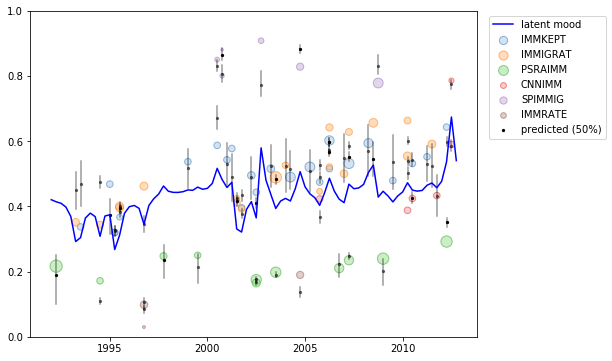

In [143]:
fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

In [144]:
from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

log_p_new: -77.39


In [58]:
# EXTEND MODEL with weights and covariates

model = """
/*
* Simple latent space model for mood
*/

data {
  int N; // number of polls
  int T; // number of time steps
  int Q; // number of different questions
  int K; // number of covariates
  row_vector[K] X[T];  // covariates: shape of matrix[T, K]
  int y[N]; // poll results
  int t[N]; // time indicies of polls
  int n[N]; // sample size for each poll
  row_vector[Q] q[N];  // indicators for poll questions
  int N_new;          // number of test points
  int y_new[N_new];
  int t_new[N_new];
  int n_new[N_new];
  row_vector[Q] q_new[N_new];
}
parameters {
  real<lower=0, upper=1> p_t_0; // unconstrained latent mood at timestep 0
  vector[T] mu;  // latent mood variable in real space
  real<lower=0> sigma_mu;  // variance of transitions in mu
  vector[Q] offsets; // offset for each question in real space
  real offset_mean;
  real<lower=0> offset_var; // offset variance 
  real alpha; // intercept in AR model
  real alpha_mean;
  real<lower=0> alpha_var;
  real beta; // weight parameter on previous mu
  real beta_mean; 
  real<lower=0> beta_var;
  vector[K] gamma; // weights on covariates
  real gamma_mean;
}
transformed parameters {  
  real mu_0;  // p_t_0 transformed to real space
  mu_0 = logit(p_t_0);
}
model {  
  sigma_mu ~ cauchy(0, 2.5);
  alpha_var ~ cauchy(0, 2.5);
  alpha_mean ~ normal(0, 1);
  alpha ~ normal(alpha_mean, alpha_var);
  beta_var ~ cauchy(0, 2.5);
  beta_mean ~ normal(1, 1);  // assume mu[t] \approx mu[t-1] as a prior
  beta ~ normal(beta_mean, beta_var);
  gamma_mean ~ normal(0, 1);
  for (k in 1:K)
    gamma[k] ~ normal(gamma_mean, beta_var);  // use same variance as weight on previous mu

  p_t_0 ~ uniform(0, 1);
  mu[1] ~ normal(alpha + beta * mu_0 + X[1] * gamma, sigma_mu);
  for (j in 2:T) {
    mu[j] ~ normal(alpha + beta * mu[j-1] + X[j] * gamma, sigma_mu);
  }
  offset_var ~ cauchy(0, 2.5);
  offset_mean ~ normal(0, 1);
  for (k in 1:Q) {
     offsets[k] ~ normal(offset_mean, offset_var);
  }
  for (i in 1:N) {
    y[i] ~ binomial_logit(n[i], mu[t[i]] + q[i] * offsets);
  }
}
generated quantities {
  vector[T] p_t; // mu variables transformed into (0, 1)
  vector[N] p_i; 
  vector[N_new] p_i_new;

  // store the log prob of held out observations
  real log_p_new;        // posterior predictive log density remaining trials
  vector[N_new] log_p_news;  // posterior predictive log density for item  
  
  // store simulated draws from the posterior
  int<lower=0> s_new[N_new];

  for (j in 1:T)
    p_t[j] = inv_logit(mu[j] + offset_mean);
  for (i in 1:N)
    p_i[i] = inv_logit(mu[t[i]] + q[i] * offsets);
  for (i in 1:N_new)
    p_i_new[i] = inv_logit(mu[t_new[i]] + q_new[i] * offsets);

  // calculate likelihood of held-out data
  for (i in 1:N_new)
    log_p_news[i] = binomial_lpmf(y_new[i] | n_new[i], p_i_new[i]);
  log_p_new = sum(log_p_news);  // sum the log probs of each obseration
  
  // simluate data from posterior for posterior predictive checks
  for (i in 1:N_new) {
    s_new[i] = binomial_rng(n_new[i], p_i_new[i]);
  }
}
"""



In [137]:
tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy
X = np.vstack([tones, logStories, entropy, toneXentropy]).T
n_periods, K = X.shape
n_polls, _ = polls.shape
periods = np.array(polls.p_quarter.values, dtype=int) + 1
n_questions = int(polls.question.max() + 1) 
question_indices = np.array(polls.question.values, dtype=int) + 1
question_indicators = np.zeros([n_polls, n_questions])
for i in range(n_polls):
    question_indicators[i, polls.question.values[i]] = 1
    
y = np.array((polls.value * polls.N).values, dtype=int)
t = np.array(polls.p_quarter.values, dtype=int) + 1
stan_data = {'N': n_polls, 'T': n_periods, 'K': K, 'Q': n_questions,
             'y': y, 't': periods, 'n': polls.N.values, 'q': question_indicators, 'X': X,
             'N_new': n_polls,
             'y_new': y, 't_new': periods, 'n_new': polls.N.values, 'q_new': question_indicators}
n_chains = 4
n_iter = 2000
fit = pystan.stan(model_code=model, data=stan_data, iter=n_iter, chains=4)


/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4acb99437be88a723d3f97b7abdb2e99 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
[ 0.07356915  0.08434608 -0.00838747  0.04680684]
[-0.52782407 -0.07522242 -0.07369195 -0.3074545 ]
[ 0.82617142  0.30006196  0.04368503  0.39171107]


''

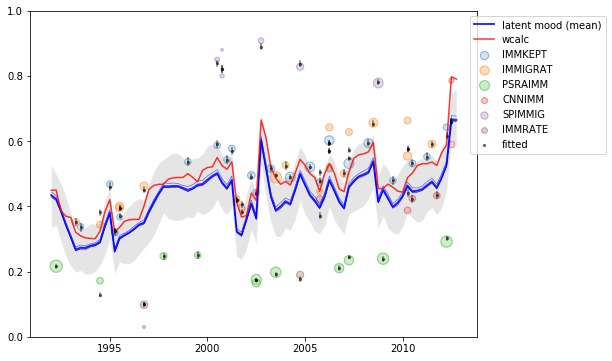

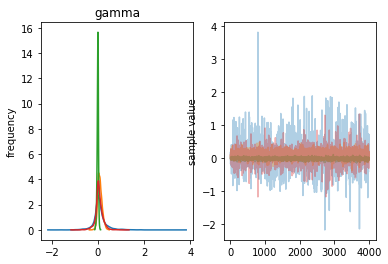

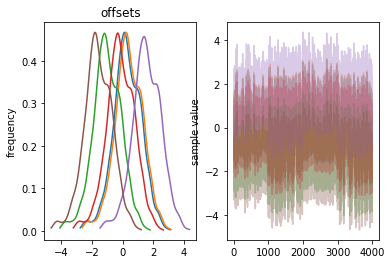

In [138]:
reload(plotting)

p_t = fit.extract('p_t')['p_t']
p_i = fit.extract('p_i')['p_i']
p_t_means = np.mean(p_t, axis=0)
p_t_25 = np.percentile(p_t, 25, axis=0)
p_t_75 = np.percentile(p_t, 75, axis=0)
p_i_means = np.mean(p_i, axis=0)
p_i_25 = np.percentile(p_i, 25, axis=0)
p_i_75 = np.percentile(p_i, 75, axis=0)
fig, ax = plotting.plot_polling_data(polls)
x = [first_year + (q) * 0.25 for q in range(n_periods)]
ax.fill_between(x,  p_t_25, p_t_75, facecolor='grey', edgecolor='white', alpha=0.2, label=None)
for i in range(n_chains):
    ax.plot(x, np.mean(p_t[i*n_iter/2:(i+1)*n_iter/2, :], axis=0), 'b', linewidth=0.5, alpha=0.8, label=None)    
ax.plot(x, p_t_means, 'b', linewidth=2, alpha=0.8, label='latent mood (mean)')
ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
ax.scatter(polls.f_date, p_i_means, s=5, facecolor='black', edgecolor='black', label='fitted', alpha=0.5)
for i in range(n_polls):
    f_date = polls.f_date.iloc[i]
    ax.plot([f_date, f_date], [p_i_25[i], p_i_75[i]], 'k', label=None, alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

#fit.plot('alpha')
#fit.plot('beta')
fit.plot('gamma')
fit.plot('offsets')

gamma = fit.extract('gamma')['gamma']
print np.mean(gamma, axis=0)
print np.percentile(gamma, 2.5, axis=0)
print np.percentile(gamma, 97.5, axis=0)

""

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 2)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[  7.42452082e-01   3.24055311e-04]
[  5.53477498e-01   2.09563797e-04]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[  5.43836776e-01   2.64584697e-04]
[  5.03089513e-01   1.98579654e-04]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[  7.25155428e-01   4.19364090e-04]
[  6.06146065e-01   2.26398742e-04]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[  9.14515728e-01   2.29842710e-04]
[  7.68654664e-01   3.00533472e-04]
fold 4
[  7.03032583e-01   2.95263790e-04]
[  5.46027773e-01   2.17815281e-04]
log_p_new: -80.08


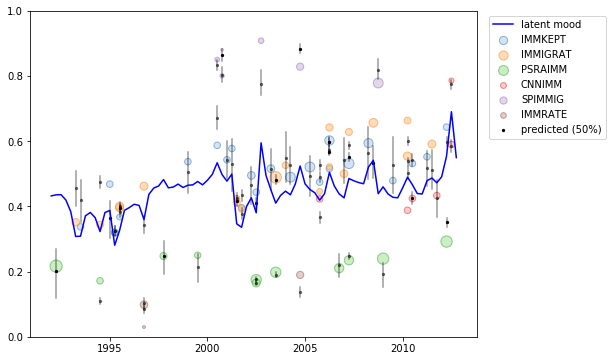

In [148]:
# TONE, STORIES

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
stories = grouped.stories.values
#toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, stories]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 2)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.71273818  0.25711523]
[ 0.25812113  0.13111273]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.51541109  0.18607489]
[ 0.20805254  0.11246281]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.62335562  0.25317602]
[ 0.26744052  0.12395532]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.85619054  0.16786402]
[ 0.31722011  0.1562117 ]
fold 4
[ 0.61581542  0.21047951]
[ 0.22459032  0.11658669]
log_p_new: -71.31


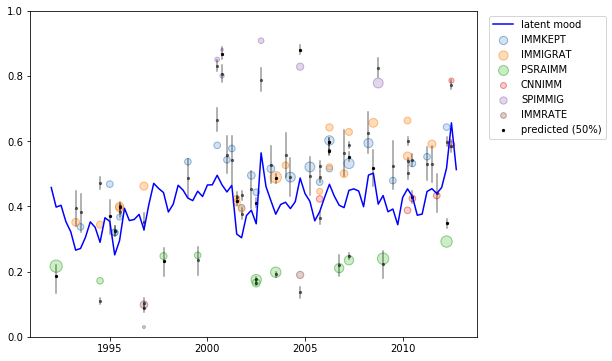

In [13]:
# aTONE, logSTORIES

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)


#### TRY USING annotator tones
tones = grouped.tone_a.values
logStories = grouped.logStories.values
#toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 3)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.68673141  0.2243249   0.20620966]
[ 0.24721073  0.12624298  0.48326154]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.49874259  0.16348346  0.13769731]
[ 0.22496044  0.12525309  0.49208526]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.61443574  0.21842729  0.45934005]
[ 0.26070718  0.13537996  0.49638051]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.86269707  0.14859629  0.2323937 ]
[ 0.34575402  0.15811366  0.6086654 ]
fold 4
[ 0.57668634  0.19676667  0.12796825]
[ 0.24017685  0.11883789  0.48585532]
log_p_new: -73.44


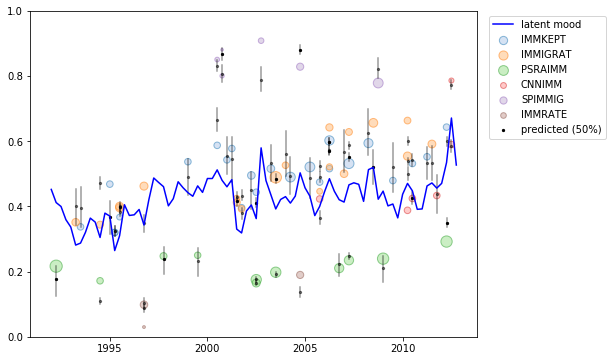

In [14]:
# aTONE, logSTORIES, aTONE x logSTORIES

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone_a.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, toneXlogStories]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 1)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


0.873411320045
0.651128807537
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


0.787286883372
0.556246524556
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


1.10039963455
0.72363913538
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


0.630215900927
0.845380161139
fold 4
0.818981176592
0.650689744296
log_p_new: -79.71


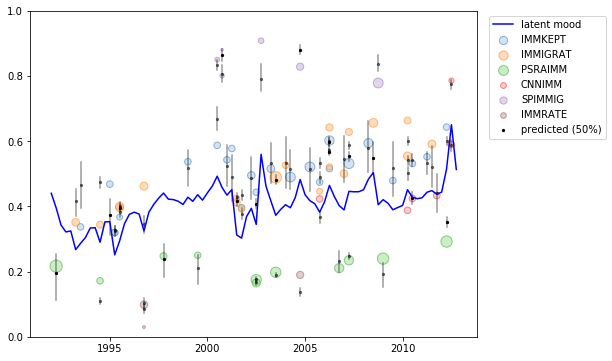

In [152]:
#  TONE x logSTORIES

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([toneXlogStories]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 3)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.68678401  0.23256519 -0.47332991]
[ 0.24742866  0.1195056   0.59327464]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.46149144  0.14101795 -1.03262003]
[ 0.20234387  0.1015017   0.64918074]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.61406727  0.23350337 -0.4324585 ]
[ 0.23398616  0.12025541  0.58425347]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.83825753  0.14954163 -0.5643864 ]
[ 0.2998007   0.1582342   0.70883557]
fold 4
[ 0.58509427  0.19430779 -0.52876337]
[ 0.23587909  0.11741234  0.65315738]
log_p_new: -75.38


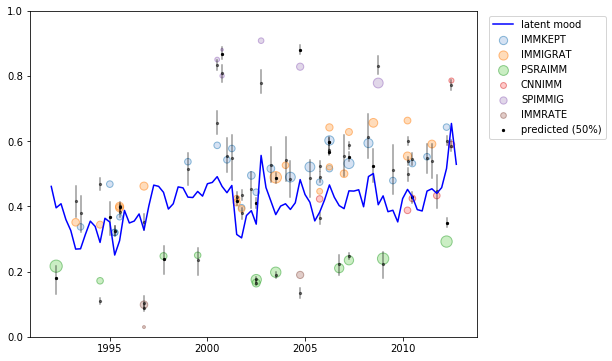

In [19]:
# aTONE, logSTORIES, ENTROPY

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone_a.values
logStories = grouped.logStories.values
#toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, entropy]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 4)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.26781093  0.22620928 -0.27215661  0.19694398]
[ 0.94295457  0.10910944  0.58669837  0.39948545]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.51586898  0.15424532 -0.96488372 -0.00262341]
[ 1.28854793  0.10060661  0.6770911   0.5434453 ]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.24583616  0.22338499 -0.17536868  0.19016683]
[ 0.5740958   0.10664951  0.46906493  0.24753248]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.29215401  0.17356537 -0.12538939  0.260542  ]
[ 0.71840784  0.14070093  0.53309633  0.31678118]
fold 4
[ 0.34833269  0.18588176 -0.48841789  0.11911331]
[ 0.94883864  0.10099375  0.62146717  0.39854854]
log_p_new: -72.50


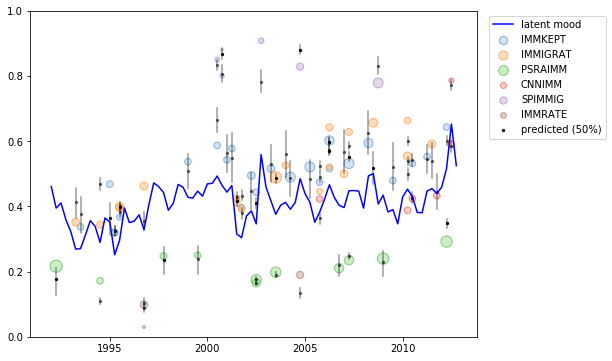

In [15]:
# aTONE, logSTORIES, ENTROPY, aTONE x ENTROPY

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone_a.values
logStories = grouped.logStories.values
#toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, entropy, toneXentropy]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/dallas/.conda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
(84, 5)
fold 0


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.20915492  0.21605369 -0.19867121  0.10568449  0.22547811]
[ 0.50010968  0.11060044  0.50697027  0.37585778  0.21842899]
fold 1


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.24812976  0.15217484 -0.63927881 -0.06869901  0.10001388]
[ 0.83062828  0.10734769  0.67958589  0.46012036  0.35578675]
fold 2


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.37422108  0.20231446 -0.24599513  0.30869824  0.13852837]
[ 0.92537207  0.1184789   0.55283149  0.46926745  0.39037666]
fold 3


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


[ 0.24210505  0.16743677 -0.16761146  0.09353952  0.28021913]
[ 0.54350737  0.14602435  0.53931276  0.46011736  0.24943492]
fold 4
[ 0.30674016  0.18454536 -0.3731053   0.00315191  0.13657215]
[ 0.74581911  0.11646605  0.59942952  0.44031941  0.31858781]
log_p_new: -78.94


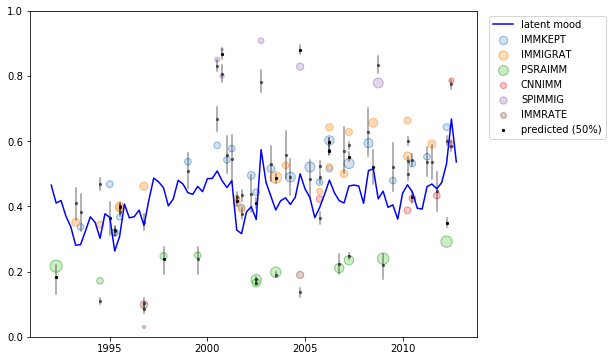

In [16]:
# aTONE, logSTORIES, ENTROPY, aTONE x logSTORIES, aTONE x ENTROPY

fig, ax = plotting.plot_polling_data(polls)

n_questions = int(polls.question.max() + 1)
n_periods = len(grouped.index)
#ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
p_t_mean = np.zeros(n_periods)

tones = grouped.tone_a.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy

X = np.vstack([tones, logStories, entropy, toneXlogStories, toneXentropy]).T
n_periods, K = X.shape
print X.shape

n_folds = 5
for fold in range(n_folds):
    print "fold", fold
    polls_train = polls[polls.fold != fold]
    polls_test = polls[polls.fold == fold]
    N_train, _ = polls_train.shape
    N_test, _ = polls_test.shape
    question_indices = np.array(polls.question.values, dtype=int) + 1
    question_indicators_train = np.zeros([N_train, n_questions])
    question_indicators_test = np.zeros([N_test, n_questions])
    for i in range(N_train):
        question_indicators_train[i, polls_train.question.values[i]] = 1
    for i in range(N_test):
        question_indicators_test[i, polls_test.question.values[i]] = 1

    y_train = np.array((polls_train.value * polls_train.N).values, dtype=int)
    y_test = np.array((polls_test.value * polls_test.N).values, dtype=int)
    t_train = np.array(polls_train.period.values, dtype=int) + 1
    t_test = np.array(polls_test.period.values, dtype=int) + 1
        
    stan_data = {'N': N_train, 'T': n_periods, 'K':K, 'Q': n_questions,
                 'y': y_train, 't': t_train, 'n': polls_train.N.values, 'q': question_indicators_train, 'X': X,
                 'N_new': N_test,
                 'y_new': y_test, 't_new': t_test, 'n_new': polls_test.N.values, 'q_new': question_indicators_test}
    fit = pystan.stan(model_code=model, data=stan_data, iter=1000, chains=4)

    p_t = fit.extract('p_t')['p_t']
    p_t_mean += np.mean(p_t, axis=0)
    p_i_new = fit.extract('p_i_new')['p_i_new']
    p_i_new_means = np.mean(p_i_new, axis=0)
    p_i_new_25 = np.percentile(p_i_new, 25, axis=0)
    p_i_new_75 = np.percentile(p_i_new, 75, axis=0)
    s_new = fit.extract('s_new')['s_new'] 
    s_new_mean = np.mean(s_new, axis=0) / polls_test.N.values
    s_new_25 = np.percentile(s_new, 25, axis=0) / polls_test.N.values
    s_new_75 = np.percentile(s_new, 75, axis=0) / polls_test.N.values
    x = [first_year + (q) * 0.25 for q in range(n_periods)]
    #ax.fill_between(x,  p_t_means+p_t_std*2, p_t_means-p_t_std*2, facecolor='grey', edgecolor='white', alpha=0.3, label=None)
    if fold == 0:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label='latent mood')
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label='predicted (50%)')
    else:
        #ax.plot(x, p_t_means, 'b', alpha=0.4, label=None)
        ax.scatter(polls_test.f_date, s_new_mean, s=5, facecolor='black', edgecolor='black', label=None, alpha=0.5)
    for i in range(N_test):
        f_date = polls_test.f_date.iloc[i]
        ax.plot([f_date, f_date], [s_new_25[i], s_new_75[i]], 'k', label=None, alpha=0.4)
        
    gamma = fit.extract('gamma')['gamma']
    print np.mean(gamma, axis=0)
    print np.std(gamma, axis=0)

ax.plot(x, p_t_mean/float(n_folds), 'b', label='latent mood')
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

from scipy.misc import logsumexp
log_p_new = fit.extract('log_p_new')['log_p_new']
n_iter = log_p_new.size
posterior_predictive = logsumexp(log_p_new) - np.log(n_iter)
print "log_p_new: %0.2f" % posterior_predictive

In [62]:
tones = grouped.tone.values
logStories = grouped.logStories.values
toneXlogStories = tones * logStories
entropy = grouped.entropy.values
toneXentropy = tones * entropy
d_pro = grouped.d_pro.values / 60.0
d_anti = grouped.d_anti.values / 60.0
X = np.vstack([d_pro, d_anti]).T
n_periods, K = X.shape
n_polls, _ = polls.shape
periods = np.array(polls.p_quarter.values, dtype=int) + 1
n_questions = int(polls.question.max() + 1) 
question_indices = np.array(polls.question.values, dtype=int) + 1
question_indicators = np.zeros([n_polls, n_questions])
for i in range(n_polls):
    question_indicators[i, int(polls.question.values[i])] = 1
    
y = np.array((polls.value * polls.N).values, dtype=int)
t = np.array(polls.p_quarter.values, dtype=int) + 1
stan_data = {'N': n_polls, 'T': n_periods, 'K': K, 'Q': n_questions,
             'y': y, 't': periods, 'n': polls.N.values, 'q': question_indicators, 'X': X,
             'N_new': n_polls,
             'y_new': y, 't_new': periods, 'n_new': polls.N.values, 'q_new': question_indicators}
n_chains = 4
n_iter = 3000
fit = pystan.stan(model_code=model, data=stan_data, iter=n_iter, chains=4)
print "Done"

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595318e2724ae8a5a2333ad2aa51278 NOW.


Done


Question	Responses
 IMMKEPT	24
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3
[ 0.00893916  0.00617333]
[-0.00261776 -0.00349021]
[ 0.02130372  0.01572179]


''

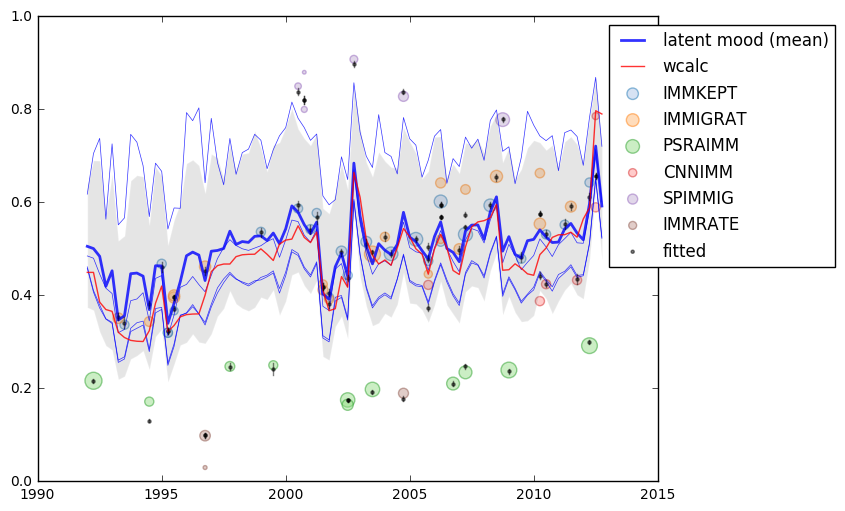

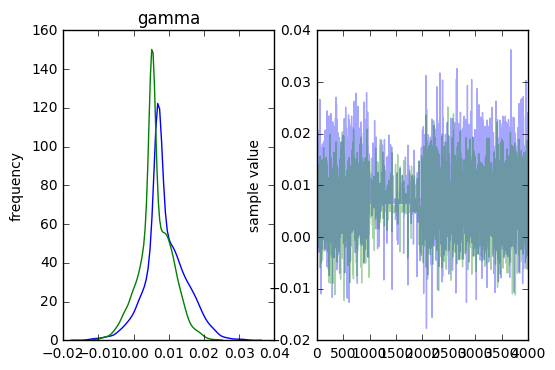

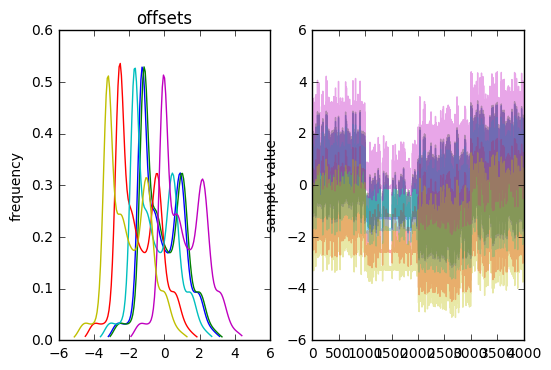

In [63]:
reload(plotting)

p_t = fit.extract('p_t')['p_t']
p_i = fit.extract('p_i')['p_i']
p_t_means = np.mean(p_t, axis=0)
p_t_25 = np.percentile(p_t, 25, axis=0)
p_t_75 = np.percentile(p_t, 75, axis=0)
p_i_means = np.mean(p_i, axis=0)
p_i_25 = np.percentile(p_i, 25, axis=0)
p_i_75 = np.percentile(p_i, 75, axis=0)
fig, ax = plotting.plot_polling_data(polls)
x = [first_year + (q) * 0.25 for q in range(n_periods)]
ax.fill_between(x,  p_t_25, p_t_75, facecolor='grey', edgecolor='white', alpha=0.2, label=None)
for i in range(n_chains):
    ax.plot(x, np.mean(p_t[i*n_iter/2:(i+1)*n_iter/2, :], axis=0), 'b', linewidth=0.5, alpha=0.8, label=None)    
ax.plot(x, p_t_means, 'b', linewidth=2, alpha=0.8, label='latent mood (mean)')
ax.plot(grouped.f_date, grouped.mood, 'r', alpha=0.8, label='wcalc')
ax.scatter(polls.f_date, p_i_means, s=5, facecolor='black', edgecolor='black', label='fitted', alpha=0.5)
for i in range(n_polls):
    f_date = polls.f_date.iloc[i]
    ax.plot([f_date, f_date], [p_i_25[i], p_i_75[i]], 'k', label=None, alpha=0.5)
ax.legend(loc='upper right', scatterpoints=1, bbox_to_anchor=(1.3,1))

#fit.plot('alpha')
#fit.plot('beta')
fit.plot('gamma')
fit.plot('offsets')

gamma = fit.extract('gamma')['gamma']
print np.mean(gamma, axis=0)
print np.percentile(gamma, 2.5, axis=0)
print np.percentile(gamma, 97.5, axis=0)

""

In [65]:
print fit

Inference for Stan model: anon_model_a595318e2724ae8a5a2333ad2aa51278.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p_t_0            0.46     0.1   0.26   0.08   0.21   0.43   0.69   0.95    7.0   1.19
mu[0]             0.2    0.37   1.04  -1.97  -0.51    0.4   0.83   2.29    8.0   1.27
mu[1]            0.19    0.53   1.19  -2.14  -0.83   0.43   1.25   2.31    5.0   1.47
mu[2]            0.11    0.66   1.31  -2.46  -0.96   0.22   1.46    2.2    4.0   1.52
mu[3]           -0.19    0.44   1.17  -2.59  -1.11   0.07   0.63   2.07    7.0   1.34
mu[4]           -0.04    0.67   1.34  -2.66  -1.14   0.02    1.4   1.95    4.0   1.53
mu[5]           -0.53    0.54    1.2  -2.88  -1.56  -0.31   0.57   1.58    5.0   1.48
mu[6]           -0.49    0.54   1.21  -2.85  -1.53  -0.27   0.62   1.62    5.0   1.49
mu[7]           -0.06     0.7   1.41 